## 데이터 불러오기

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
import seaborn as sns
import warnings

plt.rc("font", family="Gulim")
warnings.filterwarnings('ignore')

In [72]:
dat = pd.read_csv('수분방정식2.csv', encoding='euc-kr')
dat = dat.astype({'년':str, '월':str, '일':str, '시':str, '연령대':str, '피부타입':str})
dat = dat.drop(['Unnamed: 0', '스토어명', '측정기기', '채널', '광역유무2', '년', '일', '시', '시간대', '연령대', '성별'], axis=1)
dat.head(1)

,"시,도",월,연령,피부타입,수분,유분,탄력,평균 기온,강수량,평균 풍속,평균 습도,일조합,미세먼지
0,광주광역시,3,21,4.0,99,32,92,8.6,101.7,2.0,61.0,213.4,49


In [73]:
# numeric, categorical로 변수 구분
numeric = ['연령', '수분', '유분', '탄력', '평균 기온', '강수량', '평균 풍속', '평균 습도', '일조합', '미세먼지']
categorical = list(set(dat.columns) - set(['연령', '피부타입', '수분', '유분', '탄력', '평균 기온', '강수량', '평균 풍속', '평균 습도', '일조합', '미세먼지', '유수분 비율']))
dat1 = dat.loc[:,numeric]
dat2 = dat.loc[:,categorical]

In [74]:
# numeric
dat1.head()

,연령,수분,유분,탄력,평균 기온,강수량,평균 풍속,평균 습도,일조합,미세먼지
0,21,99,32,92,8.6,101.7,2.0,61.0,213.4,49
1,22,99,87,92,-4.1,41.4,2.7,57.0,193.6,41
2,22,99,6,92,-0.2,24.7,2.4,60.0,184.4,55
3,22,99,40,92,28.0,144.5,3.3,67.0,286.5,47
4,23,99,65,92,24.4,28.3,2.2,60.0,224.0,40


In [75]:
# categorical
dat2.head()

,월,"시,도"
0,3,광주광역시
1,12,서울특별시
2,12,서울특별시
3,8,부산광역시
4,6,서울특별시


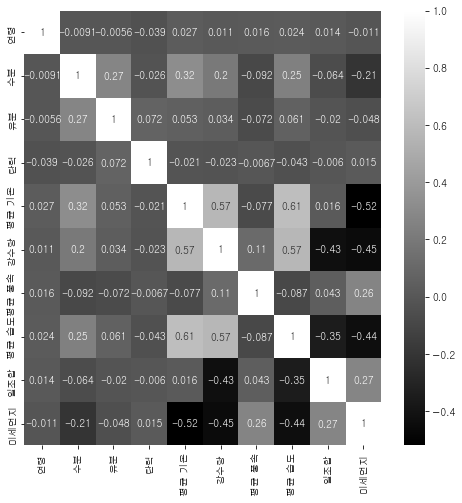

In [76]:
# numeric 상관계수 확인 --> 변수들간 큰 연관성x
corr = dat1.corr()
plt.figure(figsize=(8,8))
ax = sns.heatmap(corr, annot=True, cmap='gray')
plt.show()

In [77]:
# categorical 더미변수화
dat2 = pd.get_dummies(dat2)
dat2.head(3)

,월_1,월_10,월_11,월_12,월_2,월_3,월_4,월_5,월_6,월_7,월_8,월_9,"시,도_광주광역시","시,도_대구광역시","시,도_대전광역시","시,도_부산광역시","시,도_서울특별시","시,도_울산광역시","시,도_인천광역시","시,도_제주특별자치도"
0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [78]:
# numeric + categorical
df = pd.concat([dat1, dat2], axis=1)
df.head(3)

,연령,수분,유분,탄력,평균 기온,강수량,평균 풍속,평균 습도,일조합,미세먼지,...,월_8,월_9,"시,도_광주광역시","시,도_대구광역시","시,도_대전광역시","시,도_부산광역시","시,도_서울특별시","시,도_울산광역시","시,도_인천광역시","시,도_제주특별자치도"
0,21,99,32,92,8.6,101.7,2.0,61.0,213.4,49,...,0,0,1,0,0,0,0,0,0,0
1,22,99,87,92,-4.1,41.4,2.7,57.0,193.6,41,...,0,0,0,0,0,0,1,0,0,0
2,22,99,6,92,-0.2,24.7,2.4,60.0,184.4,55,...,0,0,0,0,0,0,1,0,0,0


In [79]:
# 데이터셋 나누기
from sklearn.model_selection import train_test_split

X = df.drop(['수분'], axis=1)
y = df['수분']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [80]:
numeric2 = dat1.drop(['수분'], axis=1).columns.tolist()

In [81]:
# EDA결과 튀는 값들이 상당수 존재 --> numeric MinMAxScaler
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
X_train[numeric2] = sc.fit_transform(X_train[numeric2]) 
X_test[numeric2] = sc.transform(X_test[numeric2])

## 변수 선택

###  numeric Stepwise

In [82]:
X_train_2 = pd.DataFrame(X_train[numeric2].copy(), columns=numeric2)
feature_columns = numeric2

In [83]:
import statsmodels.api as sm

X_train_2 = sm.add_constant(X_train_2, has_constant='add')

In [84]:
def processSubset(X, y, feature_set):
    model = sm.OLS(y, X[list(feature_set)])
    reg = model.fit()
    AIC = reg.aic
    return {'model':reg, 'AIC':AIC}

In [85]:
import itertools

def getBest(X, y, k):
    results = []
    for combo in itertools.combinations(X.columns.difference(['const']), k):
        combo = (list(combo)+['const'])
        
        results.append(processSubset(X, y, feature_set=combo))
    models = pd.DataFrame(results)
    best_model = models.loc[models['AIC'].argmin()]
    print('Processed', models.shape[0], 'models on', k)
    
    return best_model

In [86]:
def forward(X,y,predictors):
    remaining_predictors = [p for p in X.columns.difference(['const']) if p not in predictors]
    results = []
    for p in remaining_predictors :
        results.append(processSubset(X=X, y=y, feature_set=predictors+[p]+['const']))
    
    models = pd.DataFrame(results)

    best_model = models.loc[models['AIC'].argmin()]
    print("Processed ", models.shape[0], "models on", len(predictors)+1)
    print("Selected predictors:",best_model["model"].model.exog_names,"AIC: ",best_model[0])
    return best_model

def forward_model(X,y):
    Fmodels = pd.DataFrame(columns=["AIC","model"])

    predictors = []
    
    for i in range(1,len(X.columns.difference(['const']))+1):
        Forward_result = forward(X=X, y=y, predictors=predictors)
        if i > 1 :
            if Forward_result["AIC"] > Fmodel_before:
                break
        Fmodels.loc[i] = Forward_result
        predictors = Fmodels.loc[i]["model"].model.exog_names
        Fmodel_before = Fmodels.loc[i]["AIC"]
        predictors = [k for k in predictors if k != 'const']

    return (Fmodels['model'][len(Fmodels['model'])])

In [87]:
def backward(X,y,predictors):
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors) - 1):
        results.append(processSubset(X=X,y=y,feature_set=list(combo)+['const']))
    models = pd.DataFrame(results)
    
    best_model = models.loc[models['AIC'].argmin()]
    
    print("Processed ", models.shape[0], "models on", len(predictors) - 1)
    print("Selected predictors:",best_model['model'].model.exog_names,' AIC:',best_model[0])
    return best_model
    
def backward_model(X,y) :
    Bmodels = pd.DataFrame(columns=["AIC","model"], index = range(1,len(X.columns)))
    predictors = X.columns.difference(['const'])
    Bmodel_before = processSubset(X,y,predictors)['AIC']
    while (len(predictors) > 1):
        Backward_result = backward(X=X, y=y, predictors=predictors)
        if Backward_result['AIC'] > Bmodel_before :
            break
        Bmodels.loc[len(predictors) -1] = Backward_result
        predictors = Bmodels.loc[len(predictors) - 1]['model'].model.exog_names
        Bmodel_before = Backward_result["AIC"]
        predictors = [k for k in predictors if k != 'const']

    return (Bmodels["model"].dropna().iloc[0])

In [88]:
def Stepwise_model(x,y):
    stepModels = pd.DataFrame(columns=["AIC","model"])
    predictors = []
    SmodelBefore = processSubset(x,y,predictors+['const'])['AIC']
    for i in range(1, len(x.columns.difference(['const']))+1):
        forwardResult = forward(x,y,predictors)
        print("forward")
        stepModels.loc[i] = forwardResult
        predictors = stepModels.loc[i]["model"].model.exog_names
        predictors = [k for k in predictors if k != 'const']
        backwordResult = backward(x,y,predictors)
        if backwordResult['AIC'] < forwardResult['AIC']:
            stepModels.loc[i] = backwordResult
            predictors=stepModels.loc[i]["model"].model.exog_names
            smodelBefore=stepModels.loc[i]["AIC"]
            predictors=[k for k in predictors if k != 'const']
            print('backward')
        if stepModels.loc[i]["AIC"] > SmodelBefore:
            break
        else:
            smodelBefore = stepModels.loc[i]["AIC"]
    return (stepModels['model'][len(stepModels['model'])])

In [89]:
Stepwise_model(X_train_2, y_train.values).summary()

Processed  9 models on 1
Selected predictors: ['평균 기온', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001915F966280>
forward
Processed  1 models on 0
Selected predictors: ['const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x00000191098E2AF0>
Processed  8 models on 2
Selected predictors: ['평균 기온', '유분', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001911ED33A30>
forward
Processed  2 models on 1
Selected predictors: ['평균 기온', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001911ED338E0>
Processed  7 models on 3
Selected predictors: ['평균 기온', '유분', '일조합', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001913DDBD7F0>
forward
Processed  3 models on 2
Selected predictors: ['평균 기온', '유분', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     8376.
Date:                Sat, 11 Jun 2022   Prob (F-statistic):               0.00
Time:                        12:02:08   Log-Likelihood:            -1.4737e+06
No. Observations:              359312   AIC:                         2.948e+06
Df Residuals:                  359302   BIC:                         2.948e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
평균 기온         15.9302      0.143    111.657      0.000      15.651      16.210
유분            12.4777      0.076    165.018      0.000      12.329      12.626
일조합           -5.3845      0.230    -23.365      0.000      -5.836      -4.933
평균 풍속         -5.4531      0.209    -26.035      0.000      -5.864      -5.043
탄력            -2.9545      0.118    -25.020      0.000      -3.186      -2.723
평균 습도          3.4873      0.192     18.172      0.000       3.111       3.863
연령            -1.4303      0.146     -9.789      0.000      -1.717      -1.144
미세먼지          -1.1901      0.249     -4.778      0.000      -1.678      -0.702
강수량           -0.7261      0.293     -2.475      0.013      -1.301      -0.151
const         39.2790      0.217    180.896      0.000      38.853      39.705
==============================================================================
Omnibus:                    38205.793   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            82602.755
Skew:                           0.668   Prob(JB):                         0.00
Kurtosis:                       4.933   Cond. No.                         24.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### numeric 모두 유의

## 선형회귀

In [90]:
import eli5
from eli5.sklearn import PermutationImportance

In [93]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [94]:
# 변수 중요도
perm_lr = PermutationImportance(lr).fit(X_test, y_test)
eli5.show_weights(perm_lr, feature_names=X.columns.tolist())

Weight,Feature
416522583184767044288512.0000 ± 2140719436509914595328.0000,"시,도_서울특별시"
265748846406917754454016.0000 ± 486430469976603623424.0000,월_2
249969639719846574817280.0000 ± 1146659511482284376064.0000,월_1
245771197538471558250496.0000 ± 1270025437427816464384.0000,월_3
238351982049208609800192.0000 ± 917564982098471026688.0000,월_4
220089865355085817577472.0000 ± 696646124089863700480.0000,월_10
216485403130794405265408.0000 ± 939552374896262643712.0000,월_5
208427935886283231985664.0000 ± 603065024207481995264.0000,월_11
204140950108931899785216.0000 ± 980719980404064911360.0000,월_7
202801728217974914940928.0000 ± 443332440135624097792.0000,월_6


In [95]:
y_pred_lr = lr.predict(X_test)

In [136]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

print('MAE: %.3f' %mean_absolute_error(y_test, y_pred_lr))
print('MSE: %.3f' %mean_squared_error(y_test, y_pred_lr))
print('MAPE: %.3f' %mean_absolute_percentage_error(y_test, y_pred_lr))

MAE: 10.608
MSE: 211.822
MAPE: 0.358


In [129]:
X_sm = sm.add_constant(X, has_constant='add')
lr_sm = sm.OLS(y, X_sm)
result = lr_sm.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     수분   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     4111.
Date:                Sat, 11 Jun 2022   Prob (F-statistic):               0.00
Time:                        15:48:32   Log-Likelihood:            -2.1038e+06
No. Observations:              513303   AIC:                         4.208e+06
Df Residuals:                  513275   BIC:                         4.208e+06
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          37.2287      0.443     84.017      0.000      36.360      38.097
연령             -0.0173      0.002    -11.385      0.000      -0.020      -0.014
유분              0.1256      0.001    196.459      0.000       0.124       0.127
탄력             -0.0326      0.001    -31.944      0.000      -0.035      -0.031
평균 기온           0.2018      0.015     13.396      0.000       0.172       0.231
강수량            -0.0029      0.000    -11.223      0.000      -0.003      -0.002
평균 풍속          -0.6083      0.071     -8.565      0.000      -0.748      -0.469
평균 습도           0.0361      0.005      7.999      0.000       0.027       0.045
일조합            -0.0167      0.001    -20.373      0.000      -0.018      -0.015
미세먼지            0.0119      0.003      3.466      0.001       0.005       0.019
월_1            -0.6461      0.221     -2.924      0.003      -1.079      -0.213
월_10            3.6454      0.107     34.115      0.000       3.436       3.855
월_11            0.9260      0.094      9.829      0.000       0.741       1.111
월_12            0.0968      0.203      0.478      0.633      -0.300       0.494
월_2            -0.3128      0.202     -1.547      0.122      -0.709       0.084
월_3             0.6382      0.121      5.294      0.000       0.402       0.874
월_4             1.6712      0.092     18.229      0.000       1.492       1.851
월_5             3.3930      0.144     23.481      0.000       3.110       3.676
월_6             5.6522      0.194     29.110      0.000       5.272       6.033
월_7             7.8786      0.264     29.885      0.000       7.362       8.395
월_8             8.3168      0.264     31.470      0.000       7.799       8.835
월_9             5.9693      0.185     32.252      0.000       5.607       6.332
시,도_광주광역시       5.5590      0.090     61.835      0.000       5.383       5.735
시,도_대구광역시       4.0314      0.094     42.993      0.000       3.848       4.215
시,도_대전광역시       3.9512      0.115     34.489      0.000       3.727       4.176
시,도_부산광역시       4.1516      0.112     37.117      0.000       3.932       4.371
시,도_서울특별시       3.8365      0.058     66.281      0.000       3.723       3.950
시,도_울산광역시       8.4457      0.137     61.592      0.000       8.177       8.714
시,도_인천광역시       3.0492      0.123     24.749      0.000       2.808       3.291
시,도_제주특별자치도     4.2041      0.190     22.093      0.000       3.831       4.577
==============================================================================
Omnibus:                    52982.309   Durbin-Watson:                   0.325
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           114537.409
Skew:                           0.651   Prob(JB):                         0.00
Kurtosis:                       4.913   Cond. No.                     1.03e+16
================================================

## 랜덤포레스트

In [109]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth=100)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=100)

In [111]:
for x, val in zip(X.columns.tolist(), rf.feature_importances_):
    print(f'{x} : %.3f' %val)

연령 : 0.261
유분 : 0.206
탄력 : 0.241
평균 기온 : 0.128
강수량 : 0.028
평균 풍속 : 0.022
평균 습도 : 0.025
일조합 : 0.029
미세먼지 : 0.024
월_1 : 0.001
월_10 : 0.001
월_11 : 0.001
월_12 : 0.001
월_2 : 0.001
월_3 : 0.001
월_4 : 0.001
월_5 : 0.001
월_6 : 0.001
월_7 : 0.002
월_8 : 0.002
월_9 : 0.001
시,도_광주광역시 : 0.003
시,도_대구광역시 : 0.002
시,도_대전광역시 : 0.002
시,도_부산광역시 : 0.005
시,도_서울특별시 : 0.004
시,도_울산광역시 : 0.003
시,도_인천광역시 : 0.002
시,도_제주특별자치도 : 0.001


In [112]:
perm_rf = PermutationImportance(rf).fit(X_test, y_test)
eli5.show_weights(perm_rf, feature_names=X.columns.tolist())

Weight,Feature
0.1980 ± 0.0026,평균 기온
0.1936 ± 0.0012,유분
0.0602 ± 0.0017,탄력
0.0315 ± 0.0019,연령
0.0036 ± 0.0006,"시,도_울산광역시"
0.0004 ± 0.0005,"시,도_부산광역시"
-0.0000 ± 0.0001,"시,도_제주특별자치도"
-0.0006 ± 0.0000,월_5
-0.0007 ± 0.0002,"시,도_대전광역시"
-0.0007 ± 0.0000,월_9


In [113]:
y_pred_rf = rf.predict(X_test)

In [114]:
print('MAE: %.3f' %mean_absolute_error(y_test, y_pred_rf))
print('MSE: %.3f' %mean_squared_error(y_test, y_pred_rf))
print('MAPE: %.3f' %mean_absolute_percentage_error(y_test, y_pred_rf))

MAE: 10.886
MSE: 220.942
MAPE: 0.358


# 연속형만

In [130]:
X_train_2 = X_train[numeric2]
X_test_2 = X_test[numeric2]

## 선형회귀

In [131]:
lr_2 = LinearRegression()
lr_2.fit(X_train_2, y_train)

LinearRegression()

In [132]:
# 변수 중요도
perm_lr_2 = PermutationImportance(lr_2).fit(X_test_2, y_test)
eli5.show_weights(perm_lr_2, feature_names=X_test_2.columns.tolist())

Weight,Feature
0.1536 ± 0.0016,평균 기온
0.1261 ± 0.0023,유분
0.0049 ± 0.0006,일조합
0.0041 ± 0.0005,평균 풍속
0.0033 ± 0.0003,평균 습도
0.0029 ± 0.0003,탄력
0.0005 ± 0.0001,연령
0.0003 ± 0.0000,미세먼지
0.0000 ± 0.0001,강수량


In [134]:
y_pred_lr_2 = lr2.predict(X_test_2)

In [137]:
print('MAE: %.3f' %mean_absolute_error(y_test, y_pred_lr_2))
print('MSE: %.3f' %mean_squared_error(y_test, y_pred_lr_2))
print('MAPE: %.3f' %mean_absolute_percentage_error(y_test, y_pred_lr_2))

MAE: 10.626
MSE: 212.678
MAPE: 0.358


In [139]:
X_sm_2 = sm.add_constant(X[numeric2], has_constant='add')
lr_sm_2 = sm.OLS(y, X_sm_2)
result_2 = lr_sm_2.fit()
result_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     수분   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                 1.203e+04
Date:                Sat, 11 Jun 2022   Prob (F-statistic):               0.00
Time:                        15:52:10   Log-Likelihood:            -2.1049e+06
No. Observations:              513303   AIC:                         4.210e+06
Df Residuals:                  513293   BIC:                         4.210e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.0721      0.270    159.572      0.000      42.543      43.601
연령            -0.0193      0.002    -12.788      0.000      -0.022      -0.016
유분             0.1256      0.001    196.655      0.000       0.124       0.127
탄력            -0.0306      0.001    -30.052      0.000      -0.033      -0.029
평균 기온          0.4376      0.003    133.104      0.000       0.431       0.444
강수량           -0.0006      0.000     -2.698      0.007      -0.001      -0.000
평균 풍속         -1.1827      0.037    -31.729      0.000      -1.256      -1.110
평균 습도          0.0585      0.003     21.860      0.000       0.053       0.064
일조합           -0.0199      0.001    -28.264      0.000      -0.021      -0.019
미세먼지          -0.0161      0.002     -7.018      0.000      -0.021      -0.012
==============================================================================
Omnibus:                    54511.919   Durbin-Watson:                   0.319
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           117824.956
Skew:                           0.667   Prob(JB):                         0.00
Kurtosis:                       4.931   Cond. No.                     3.47e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.47e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 랜덤포레스트

In [142]:
rf_2 = RandomForestRegressor(max_depth=100)
rf_2.fit(X_train_2, y_train)

RandomForestRegressor(max_depth=100)

In [143]:
for x, val in zip(X_test_2.columns.tolist(), rf_2.feature_importances_):
    print(f'{x} : %.3f' %val)

연령 : 0.263
유분 : 0.208
탄력 : 0.243
평균 기온 : 0.133
강수량 : 0.033
평균 풍속 : 0.028
평균 습도 : 0.030
일조합 : 0.034
미세먼지 : 0.029


In [145]:
perm_rf_2 = PermutationImportance(rf_2).fit(X_test_2, y_test)
eli5.show_weights(perm_rf_2, feature_names=X_test_2.columns.tolist())

Weight,Feature
0.2240 ± 0.0012,평균 기온
0.1909 ± 0.0025,유분
0.0586 ± 0.0022,탄력
0.0322 ± 0.0047,연령
-0.0083 ± 0.0017,미세먼지
-0.0090 ± 0.0017,일조합
-0.0155 ± 0.0009,강수량
-0.0166 ± 0.0007,평균 습도
-0.0170 ± 0.0014,평균 풍속


In [147]:
y_pred_rf_2 = rf_2.predict(X_test_2)

In [148]:
print('MAE: %.3f' %mean_absolute_error(y_test, y_pred_rf_2))
print('MSE: %.3f' %mean_squared_error(y_test, y_pred_rf_2))
print('MAPE: %.3f' %mean_absolute_percentage_error(y_test, y_pred_rf_2))

MAE: 10.893
MSE: 221.118
MAPE: 0.358
